# Data Load with Cleaning and Preprocessing

In [1]:
import os
import sys

# Add paths for custom transformers
while any(marker in os.getcwd() for marker in ('exercises', 'notebooks', 'students', 'research', 'projects')):
    os.chdir("..")
sys.path.append('.')


In [2]:
import pandas as pd
from sklearn.pipeline import make_pipeline
import seaborn as sns
from dotenv import load_dotenv
import numpy as np
import random
np.random.seed(42)
random.seed(42)
import matplotlib.pyplot as plt

# Import project-specific transformers
import projects.proj_2_team_4.src.custom_transformers as project_transformers

In [3]:
env_path = 'projects/proj_2_team_4/.env'
load_dotenv(env_path)

True

In [28]:
train_raw_path = os.getenv('TRAIN_PATH')
valid_raw_path = os.getenv('VALID_PATH')
valid_solutions_path = os.getenv('VALID_SOLUTIONS_PATH')
machine_appendix_path = os.getenv('MACHINE_APPENDIX_PATH')
train_preprocessed_log_path = os.getenv('TRAIN_PREPROCESSED_LOG_PATH')
valid_preprocessed_path = os.getenv('VALID_PREPROCESSED_PATH')
train_preprocessed_path = os.getenv('TRAIN_PREPROCESSED_PATH')
train_raw_merged_path=os.getenv('TRAIN_RAW_MERGED_PATH')
valid_raw_merged_path=os.getenv('VALID_RAW_MERGED_PATH')

In [5]:
# Load the data with proper date parsing
train_raw = pd.read_csv(train_raw_path, 
                       parse_dates=['saledate'],
                       low_memory=False)

# Load validation data and solutions
valid_raw = pd.read_csv(valid_raw_path, 
                       parse_dates=['saledate'],
                       low_memory=False)
valid_solutions = pd.read_csv(valid_solutions_path)

# Join validation data with solutions
valid_raw = valid_raw.merge(valid_solutions[['SalesID', 'SalePrice']], on='SalesID', how='left')

# Join train and validation data with manufacturer
appendix = pd.read_csv(machine_appendix_path)
# train_raw = train_raw.merge(appendix[['ModelID', 'fiManufacturerDesc']], on='ModelID', how='left', sort=False)
# valid_raw = valid_raw.merge(appendix[['ModelID', 'fiManufacturerDesc']], on='ModelID', how='left', sort=False)

In [6]:
# Kernel keeps dying during merge above. I am using tqdm
from tqdm import tqdm

lookup = appendix.set_index('ModelID')['fiManufacturerDesc'].to_dict()

def slow_fill(df):
    return [lookup.get(mid, None) for mid in tqdm(df['ModelID'])]

train_raw['fiManufacturerDesc'] = slow_fill(train_raw)
valid_raw['fiManufacturerDesc'] = slow_fill(valid_raw)


100%|██████████| 11573/11573 [00:00<00:00, 4070497.29it/s]


## Analyzing Data Types, Missing Values and Duplicates

In [7]:
print("Data Info:")
train_raw.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object     

In [8]:
print("\nMissing Values:")
missing = train_raw.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))


Missing Values:
Pushblock                   375906
Tip_Control                 375906
Engine_Horsepower           375906
Enclosure_Type              375906
Blade_Width                 375906
Blade_Extension             375906
Scarifier                   375895
Hydraulics_Flow             357763
Grouser_Tracks              357763
Coupler_System              357667
fiModelSeries               344217
Steering_Controls           331756
Differential_Type           331714
UsageBand                   331486
fiModelDescriptor           329206
Backhoe_Mounting            322453
Stick                       321991
Turbocharged                321991
Pad_Type                    321991
Blade_Type                  321292
Travel_Controls             321291
Tire_Size                   306407
Track_Type                  301972
Grouser_Type                301972
Pattern_Changer             301907
Stick_Length                301907
Thumb                       301837
Undercarriage_Pad_Width     301253
Rip

In [9]:
num_dupes_train = train_raw.duplicated().sum()
print(f"\nNumber of duplicate rows in train data: {num_dupes_train}")


Number of duplicate rows in train data: 0


## Analyzing Categorical Variables

In [10]:
# Check cardinality of categorical columns
categorical_cols = train_raw.select_dtypes(include=['object']).columns
cardinality = {col: train_raw[col].nunique() for col in categorical_cols}
print("Number of unique values in categorical columns:")
for col, count in sorted(cardinality.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count}")

Number of unique values in categorical columns:
fiModelDesc: 4999
fiBaseModel: 1950
fiSecondaryDesc: 175
fiModelDescriptor: 139
fiModelSeries: 122
fiManufacturerDesc: 104
fiProductClassDesc: 74
state: 53
Stick_Length: 29
Undercarriage_Pad_Width: 19
Tire_Size: 17
Hydraulics: 12
Blade_Type: 10
Transmission: 8
Travel_Controls: 7
ProductSize: 6
ProductGroup: 6
ProductGroupDesc: 6
Enclosure: 6
Blade_Width: 6
Steering_Controls: 5
Drive_System: 4
Pad_Type: 4
Ripper: 4
Differential_Type: 4
UsageBand: 3
Ride_Control: 3
Enclosure_Type: 3
Tip_Control: 3
Coupler: 3
Hydraulics_Flow: 3
Thumb: 3
Pattern_Changer: 3
Grouser_Type: 3
Forks: 2
Stick: 2
Turbocharged: 2
Blade_Extension: 2
Engine_Horsepower: 2
Pushblock: 2
Scarifier: 2
Coupler_System: 2
Grouser_Tracks: 2
Track_Type: 2
Backhoe_Mounting: 2


## Cleaning and Preprocessing pipeline

In [11]:
# Define column groups based on cardinality and semantics
id_cols = ['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'fiModelDesc']

# Measurement columns that need numeric extraction
measurement_cols = [
    'Tire_Size', 'Undercarriage_Pad_Width', 'Stick_Length'
]

# Low cardinality categorical columns for one-hot encoding
categorical_cols = [
    'ProductGroup', 'ProductGroupDesc', 'Enclosure_Type',
    'Coupler', 'Hydraulics_Flow', 'Track_Type',
    'Grouser_Type', 'Steering_Controls', 'Enclosure', 'Pad_Type',
    'Transmission', 'Hydraulics', 'Blade_Type', 'Travel_Controls', 'state', 'Drive_System', 'Stick', 'Turbocharged', 'Blade_Extension', 'Scarifier',
    'Pushblock', 'Ripper', 'Coupler_System', 'Backhoe_Mounting', 'Tip_Control', 'equipment_type', 'capacity_unit', 'Engine_Horsepower', 'Forks', 'Ride_Control', 'Thumb', 'Pattern_Changer',
    'Grouser_Tracks', 'Differential_Type', 'fiManufacturerDesc'
]

# High cardinality columns that need special handling
high_card_cols = ['fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor']

# Ordinal columns with natural ordering
ordinal_cols = [
    'UsageBand',     # Low/Medium/High usage
    'ProductSize',    # Size categories
    'Blade_Width', # <12'/12'/13'/14'/16'
]

## Cleaning

In [12]:
# Create cleaning pipeline
cleaning_pipeline = make_pipeline(
    # Step 1: Drop unnecessary columns
    project_transformers.DropColumnTransformer(
        columns=id_cols
    ),

    # Step 2: Process dates
    project_transformers.DateProcessor(),

    #Step 3: Process product classes
    project_transformers.ProductClassTransformer(),

    # Step 4: Clean and extract measurements
    project_transformers.MeasurementCleaner(),

    # Step 5: Handle missing values
    project_transformers.CustomImputer(
        strategy='median',
        columns=measurement_cols
    ),
    project_transformers.CustomImputer(
        strategy='constant',
        columns=categorical_cols + high_card_cols,
        fill_value='None or Unspecified'
    ),

    # Step 6: Remove outliers with IQR method
    project_transformers.CustomOutlierRemover(
        columns=[
            'YearMade',
            'MachineHoursCurrentMeter', 
            'sale_year',
            'sale_month',
            'machine_age',
            'Tire_Size',
            'Undercarriage_Pad_Width',
            'Stick_Length'
        ],
        threshold=2.5
    )
)

In [13]:
# Apply the pipeline
train_cleaned = cleaning_pipeline.fit_transform(train_raw)

print("Original shape:", train_raw.shape)
print("Processed shape:", train_cleaned.shape)
print("\nColumns in cleaned dataset:")
print(train_cleaned.columns.tolist())


Original shape: (401125, 54)
Processed shape: (315560, 56)

Columns in cleaned dataset:
['SalePrice', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls', 'fiManufacturerDesc', 'sale_year', 'sale_month', 'sale_quarter', 'sale_day_of_week', 'sale_is_weekend', 'machine_age', 'equipment_type', 'capacity_min', 'capacity_max', 'capacity_unit']


In [14]:
valid_cleaned = cleaning_pipeline.transform(valid_raw)

/Users/wojciechjurewicz/anaconda3/envs/mda/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [15]:
cleaning_pipeline

Pipeline(steps=[('dropcolumntransformer',
                 DropColumnTransformer(columns=['SalesID', 'MachineID',
                                                'ModelID', 'datasource',
                                                'auctioneerID',
                                                'fiModelDesc'])),
                ('dateprocessor', DateProcessor()),
                ('productclasstransformer', ProductClassTransformer()),
                ('measurementcleaner', MeasurementCleaner()),
                ('customimputer-1',
                 CustomImputer(columns=['Tire_Size', 'Undercarriage_...
                                        'Backhoe_Mounting', 'Tip_Control',
                                        'equipment_type', 'capacity_unit',
                                        'Engine_Horsepower', 'Forks',
                                        'Ride_Control', ...],
                               fill_value='None or Unspecified',
                               strategy='constant')),
                ('customoutlierremover',
                 CustomOutlierRemover(columns=['YearMade',
                                               'MachineHoursCurrentMeter',
                                               'sale_year', 'sale_month',
                                               'machine_age', 'Tire_Size',
                                               'Undercarriage_Pad_Width',
                                               'Stick_Length'],
                                      threshold=2.5))])

## Preprocessing

In [16]:
# Create preprocessing pipeline
preprocessing_pipeline = make_pipeline(
    # Step 1: Encode categorical variables
    # Label encoding for ordinal categories with custom ordering
    project_transformers.ExtendedLabelEncoder(
        columns=['UsageBand'],
        ordering={
            'UsageBand': {
                '': -1,
                'Low': 0,
                'Medium': 1,
                'High': 2
            }
        }
    ),
    project_transformers.ExtendedLabelEncoder(
        columns=['ProductSize'],
        ordering={
            'ProductSize': {
                '': -1,
                'Mini': 0,
                'Compact': 1,
                'Small': 2,
                'Medium': 3,
                'Large': 4,
                'Extra Large': 5
            }
        }
    ),
    project_transformers.ExtendedLabelEncoder(
        columns=['Blade_Width'],
        ordering={
            'Blade_Width': {
                '': -1,
                'None or Unspecified': 0,
                "<12'": 1,
                "12'": 2,
                "13'": 3,
                "14'": 4,
                "16'": 5
            }
        }
    ),
    
    # One-hot encoding for regular categorical columns
    project_transformers.ExtendedOneHotEncoder(
        columns=categorical_cols,
        handle_unknown='ignore'
    ),
    
    # One-hot encoding for high cardinality columns
    project_transformers.ExtendedOneHotEncoder(
        columns=high_card_cols,
        handle_unknown='ignore',
        max_categories=50,  # Keep only top 50 categories
        min_frequency=0.001  # Must appear in at least 0.1% of samples
    ),
    
    # Step 2: Scale numerical features
    project_transformers.CustomStandardScaler(
        columns=[
            'YearMade',
            'MachineHoursCurrentMeter',
            'sale_year',
            'sale_month',
            'sale_quarter',
            'machine_age',
            'Tire_Size',
            'Undercarriage_Pad_Width',
            'Stick_Length',
            'capacity_min',
            'capacity_max'
        ]
    )
)

In [17]:
# Apply the pipeline
train_processed = preprocessing_pipeline.fit_transform(train_cleaned)

print("Previous shape:", train_cleaned.shape)
print("Processed shape:", train_processed.shape)
print("\nColumns in processed dataset:")
print(train_processed.columns.tolist())

print("\nMissing values in processed dataset:")
missing = train_processed.isnull().sum()
print(missing[missing > 0])

Previous shape: (315560, 56)
Processed shape: (315560, 427)

Columns in processed dataset:
['SalePrice', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'ProductSize', 'Blade_Width', 'Tire_Size', 'Undercarriage_Pad_Width', 'Stick_Length', 'sale_year', 'sale_month', 'sale_quarter', 'sale_day_of_week', 'sale_is_weekend', 'machine_age', 'capacity_min', 'capacity_max', 'ProductGroup_BL', 'ProductGroup_TTT', 'ProductGroup_TEX', 'ProductGroup_WL', 'ProductGroup_SSL', 'ProductGroup_MG', 'ProductGroupDesc_Backhoe Loaders', 'ProductGroupDesc_Track Type Tractors', 'ProductGroupDesc_Track Excavators', 'ProductGroupDesc_Wheel Loader', 'ProductGroupDesc_Skid Steer Loaders', 'ProductGroupDesc_Motor Graders', 'Enclosure_Type_None or Unspecified', 'Enclosure_Type_Low Profile', 'Enclosure_Type_High Profile', 'Coupler_None or Unspecified', 'Coupler_Manual', 'Coupler_Hydraulic', 'Hydraulics_Flow_None or Unspecified', 'Hydraulics_Flow_Standard', 'Hydraulics_Flow_High Flow', 'Track_Type_None or Unspec

In [18]:
valid_processed = preprocessing_pipeline.transform(valid_cleaned)

/Users/wojciechjurewicz/anaconda3/envs/mda/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [19]:
preprocessing_pipeline

Pipeline(steps=[('extendedlabelencoder-1',
                 ExtendedLabelEncoder(columns=['UsageBand'],
                                      ordering={'UsageBand': {'': -1, 'High': 2,
                                                              'Low': 0,
                                                              'Medium': 1}})),
                ('extendedlabelencoder-2',
                 ExtendedLabelEncoder(columns=['ProductSize'],
                                      ordering={'ProductSize': {'': -1,
                                                                'Compact': 1,
                                                                'Extra Large': 5,
                                                                'Large': 4,
                                                                'Medium': 3,
                                                                'Mini': 0,
                                                                'Small': 2}})),
                ('extendedlabelencoder-3',
                 Exten...
                 ExtendedOneHotEncoder(columns=['fiBaseModel',
                                                'fiSecondaryDesc',
                                                'fiModelSeries',
                                                'fiModelDescriptor'],
                                       max_categories=50,
                                       min_frequency=0.001)),
                ('customstandardscaler',
                 CustomStandardScaler(columns=['YearMade',
                                               'MachineHoursCurrentMeter',
                                               'sale_year', 'sale_month',
                                               'sale_quarter', 'machine_age',
                                               'Tire_Size',
                                               'Undercarriage_Pad_Width',
                                               'Stick_Length', 'capacity_min',
                                               'capacity_max']))])

In [20]:
# Save preprocessed data to CSV
train_processed.to_csv(train_preprocessed_path, index=False)
print(f"Preprocessed training data saved to {train_preprocessed_path}")

Preprocessed training data saved to projects/proj_2_team_4/datasets/Train_preprocessed.csv


In [21]:
# Save preprocessed data to CSV
valid_processed.to_csv(valid_preprocessed_path, index=False)
print(f"Preprocessed training data saved to {valid_preprocessed_path}")


Preprocessed training data saved to projects/proj_2_team_4/datasets/Valid_preprocessed.csv


## Logarithmic transformation of SalePrice

This is the plot of the distribution of SalePrice before transformation.
The distribution shows significant right-skew, with most sales concentrated
in lower price ranges. A logarithmic transformation will help normalize this.

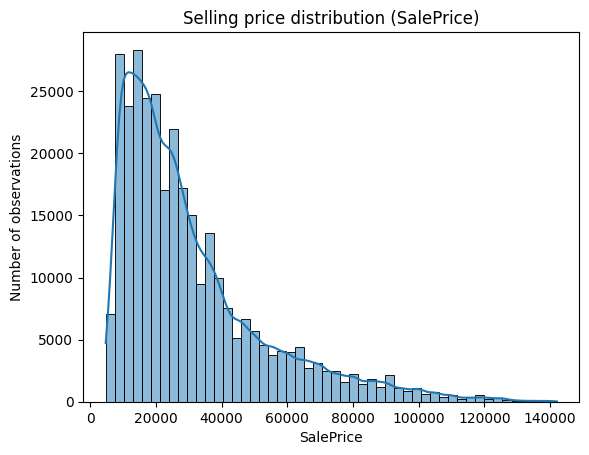

In [22]:
sns.histplot(train_processed['SalePrice'], bins=50, kde=True)
plt.title('Selling price distribution (SalePrice)')
plt.xlabel('SalePrice')
plt.ylabel('Number of observations')
plt.show()

In [23]:
train_processed_log = train_processed.copy()
train_processed_log['SalePrice'] = np.log1p(train_processed_log['SalePrice'])

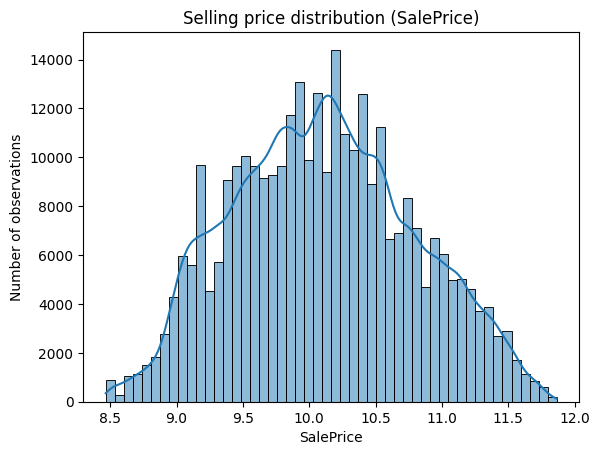

In [24]:
sns.histplot(train_processed_log['SalePrice'], bins=50, kde=True)
plt.title('Selling price distribution (SalePrice)')
plt.xlabel('SalePrice')
plt.ylabel('Number of observations')
plt.show()

After applying logarithmic transformation, the distribution appears more normally distributed with reduced skewness

In [25]:
# Save preprocessed and transformed data to CSV
train_processed_log.to_csv(train_preprocessed_log_path, index=False)
print(f"Preprocessed training data saved to {train_preprocessed_log_path}")

Preprocessed training data saved to projects/proj_2_team_4/datasets/Train_preprocessed_log.csv


In [29]:
# Save raw data with merged manufacturer and solutions for validation set
# This is for Catboost purpose

train_raw.to_csv(train_raw_merged_path, index=False)
valid_raw.to_csv(valid_raw_merged_path, index=False)